In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
from wmt_inert_tracer.swmt import swmt
from wmt_inert_tracer.compute import lbin_define
from wmt_inert_tracer.preprocessing import preprocessing

In [3]:
def load(paths):
    return xr.open_mfdataset(paths,use_cftime=True)

def calculate(ds,bins=None,group_tend=True):
    # Define a reasonable range if bins not specified
    if bins is None:
        bins = np.arange(20,30,0.1)
    # Expand bins to capture full density range
    bins = np.concatenate((np.array([0]),bins,np.array([100])))
    
    # Preprocess data
    ds = preprocessing(ds, grid=ds, decode_times=False, verbose=False)
    
    # Calculate WMT
    G = swmt(ds).G('sigma0', bins=bins, group_tend=group_tend)
    
    # If tendencies were grouped then G is a DataArray
    # For consistency in plotting function, convert it to a dataset
    if group_tend:
        G = G.to_dataset()
    return G

def plot(G):
    # Don't plot first or last bin (expanded to capture full range)
    G = G.isel(sigma0=slice(1,-1))
    levs = G['sigma0'].values
    
    # Take annual mean and load
    G = G.mean('time').load()
    # Get terms in dataset
    terms = list(G.data_vars)
    
    fig,ax = plt.subplots()
    # Plot each term
    for term in terms:
        if term =='heat':
            color='tab:red'
        elif term =='salt':
            color='tab:blue'
        else:
            color='k'
        ax.plot(levs,G[term],label=term,color=color)
        
    # If terms were not grouped then sum them up to get total
    if len(terms)>1:
        total = xr.zeros_like(G[terms[0]])
        for term in terms:
            total += G[term]
        ax.plot(levs,total,label='total',color='k')
        
    ax.legend()
    ax.set_xlabel('SIGMA0')
    ax.set_ylabel('TRANSFORMATION ($m^3s^{-1}$)')
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig

### Monthly climatology

In [4]:
pp = '/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/'
ppname = 'ocean_monthly'
path = pp+ppname+'/av/monthly_5yr/'+ppname+'.0001-0005.*.nc'
paths = glob.glob(path)
gridpath = pp+ppname+'/'+ppname+'.static.nc'
paths.append(gridpath)

In [5]:
ds = load(paths)

In [6]:
G = calculate(ds,group_tend=False)

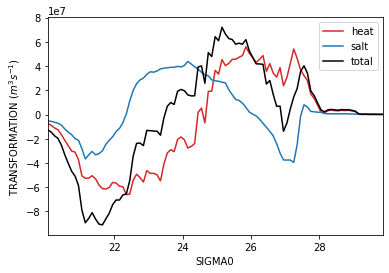

In [7]:
fig = plot(G)

### Time-series output (not developed)

In [8]:
pp = '/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/'
ppname = 'ocean_monthly'
variables = ['tos','sos','hfds','sfdsi','wfo']
paths = []
for variable in variables:
    path = pp+ppname+'/ts/monthly_5yr/'+ppname+'.0001-0005.*.'+variable+'.nc'
    paths.append(glob.glob(path))